In [2]:
from pandas import DataFrame

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import adam
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import glob
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
import sys
from pandas import DataFrame
import math
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import gc
from contextlib import redirect_stdout
import os

Using TensorFlow backend.


In [3]:
os.chdir('/content/drive/My Drive/New LSTM Crack')

In [4]:
train_files = glob.glob('./small_train/*.csv')
print('Files in use: {}'.format(len(train_files)))
# train_files = shuffle(train_files)
train_df = pd.concat([pd.read_csv(f) for f in train_files])
# train_df = train_df[:100000]
#series = train_df.iloc[:,1].to_numpy()
print(train_df)

Files in use: 39
               Time  Crack Length  Time Difference  Force
0        175.976566      0.054524          0.00000   1800
1        176.171876      0.019457          0.19531   1800
2        176.367186      0.039681          0.39062   1800
3        176.562496      0.026083          0.58593   1800
4        176.757816      0.040247          0.78125   1800
...             ...           ...              ...    ...
68047  18668.945560      0.552827      18492.96900   1800
68048  18669.140560      0.531806      18493.16400   1800
68049  18669.335560      0.542747      18493.35900   1800
68050  18669.531560      0.531918      18493.55500   1800
68051  18669.726560      0.539386      18493.75000   1800

[2654028 rows x 4 columns]


In [5]:
# For use in Multivariate Predictions
crack_change = []
crack_series = train_df.iloc[:,1].to_numpy().reshape((len(train_df),1))
print(crack_series.shape)
crack_change.append(0)

for i in range(len(crack_series)-1):
  crack_change.append(crack_series[i+1,:] - crack_series[i,:])

(2654028, 1)


In [6]:
crack_change =np.asarray(crack_change).reshape(len(train_df),1)
crack_change = crack_change.astype(np.float)

print(crack_change.shape)

(2654028, 1)


In [7]:
force_series = train_df.iloc[:,3].to_numpy().reshape((len(train_df),1))/1800
temp_series = np.full((len(train_df), 1), 300)/300

In [8]:
stress_intensity = []
specimen_width = 0.05
crossSectArea = 2.6388

for i in range(len(train_df)):
  term1 = (force_series[i] / crossSectArea) * sqrt(3.14 * crack_series[i])
  term2 = 8.574
  term3 = 10.365 * (crack_series[i] / specimen_width)
  term4 = 5.499 * ((crack_series[i] / specimen_width)**2)
  intensity = term1*(term2 - term3 + term4)
  stress_intensity.append(intensity)
  if i % 100000 == 0:
    print(i)



0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000


In [9]:
stress_intensity = np.asarray(stress_intensity).reshape(len(train_df),1)
#stress_intensity = stress_intensity / np.amax(stress_intensity) Too small to see increase
#No scaling of stress intensity 
print(stress_intensity.shape)


(2654028, 1)


In [10]:
Scaler = MinMaxScaler()
stress_intensity = Scaler.fit_transform(stress_intensity)

In [11]:
series= np.hstack((crack_change, force_series, temp_series, stress_intensity))


In [12]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

In [13]:
# split a univariate sequence
#def split_sequence(sequence, n_steps):
#	X, y = list(), list()
#	for i in range(len(sequence)):
		# find the end of this pattern
#		end_ix = i + n_steps
		# check if we are beyond the sequence
#		if end_ix > len(sequence)-1:
#			break
		# gather input and output parts of the pattern
#		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
#		X.append(seq_x)
#		y.append(seq_y)
#	return array(X), array(y)

In [14]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [15]:
train_size = int(len(series) * 0.70)
test_size = len(series) - train_size
train, test = series[0:train_size], series[train_size:len(series)]


(1857819, 4)


In [17]:
print(len(train), len(test))
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)
print(X_test.shape)

1857819 796209
(796204, 5, 4)


In [18]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 4

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [19]:
print(X_train.shape)
print(y_train)

(1857814, 5, 4)
[[-1.61786400e-02  1.00000000e+00  1.00000000e+00  3.31779939e-04]
 [ 1.10574380e-02  1.00000000e+00  1.00000000e+00  3.30483698e-04]
 [ 3.65071020e-02  1.00000000e+00  1.00000000e+00  5.91261315e-04]
 ...
 [ 2.27094400e-03  8.88888889e-01  1.00000000e+00  2.85402691e-02]
 [ 1.21739350e-02  8.88888889e-01  1.00000000e+00  3.20279429e-02]
 [-1.92852800e-03  8.88888889e-01  1.00000000e+00  3.14591139e-02]]


In [ ]:
opt = adam(learning_rate = 0.0001)
# define model
model = Sequential()
model.add(Bidirectional(LSTM(1000, activation='relu',return_sequences = True), input_shape=(n_steps, n_features)))
model.add(Dense(500))
model.add(Bidirectional(LSTM(1000, activation='relu')))
model.add(Dense(4))
model.compile(optimizer=opt, loss='mse')

In [ ]:
# fit model
#used 20 epoch Originally 
model.fit(X_train, y_train, epochs=10, verbose=1, batch_size = 500)

Epoch 1/10
714541/714541 [==============================] - 125s 174us/step - loss: 0.0046
Epoch 2/10
714541/714541 [==============================] - 123s 172us/step - loss: 1.8254e-04
Epoch 3/10
714541/714541 [==============================] - 122s 171us/step - loss: 1.6650e-04
Epoch 4/10
714541/714541 [==============================] - 122s 171us/step - loss: 1.6642e-04
Epoch 5/10
714541/714541 [==============================] - 122s 171us/step - loss: 1.6869e-04
Epoch 6/10
714541/714541 [==============================] - 122s 170us/step - loss: 1.6821e-04
Epoch 7/10
714541/714541 [==============================] - 122s 170us/step - loss: 1.6782e-04
Epoch 8/10
714541/714541 [==============================] - 122s 170us/step - loss: 1.6778e-04
Epoch 9/10
714541/714541 [==============================] - 122s 170us/step - loss: 1.6714e-04
Epoch 10/10
714541/714541 [==============================] - 122s 171us/step - loss: 1.6659e-04


In [ ]:
yhat = model.predict(X_test, verbose=1)

306229/306229 [==============================] - 38s 125us/step


In [ ]:
yhat2 = model.predict(X_train, verbose=1)

714541/714541 [==============================] - 89s 125us/step


In [ ]:
yhat = reconstructed_model.predict(X_test, verbose=1)

428723/428723 [==============================] - 58s 135us/step


In [ ]:
yhat2 = reconstructed_model.predict(X_train, verbose=1)

1000359/1000359 [==============================] - 131s 131us/step


In [ ]:
y__test = y_test + .2

In [ ]:
#series= np.hstack((crack_change, force_series, temp_series, stress_intensity))
#index 0 = dA
#index 3 = dK

print(yhat[:2])

[[0.00773338 0.99978966 1.0005945  0.01343303]
 [0.01010989 0.999856   1.0005616  0.01344806]]


All Variables Predicted Vs Real

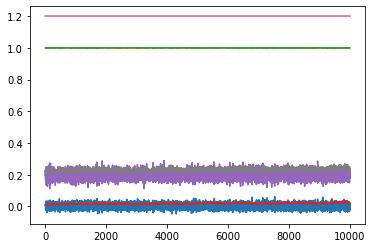

In [ ]:
plt.figure()
plt.plot(yhat[:10000])
plt.plot(y__test[:10000])
plt.show()

dA VS cycle Number

[ 0.00773338  0.01010989  0.00606625 ...  0.00449992 -0.00383537
  0.00384432]


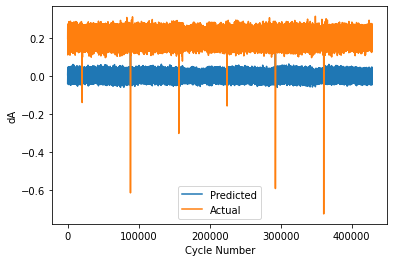

In [ ]:
print(yhat[:,0])

plt.figure()
plt.plot(yhat[:,0], label="Predicted")
plt.plot(y__test[:,0], label="Actual")
plt.xlabel("Cycle Number")
plt.ylabel("dA")
plt.legend()
plt.show()


Stress VS Cycle Number

(340260,)
(340260,)
(748562,)


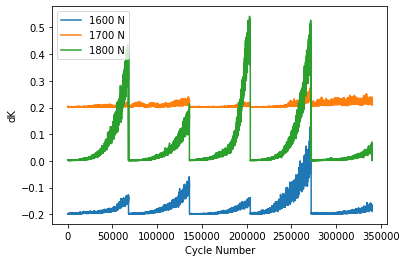

In [ ]:
N1600 = yhat2[:340260,3]
print(N1600.shape)
N1600 = N1600 - .2

N1700 = yhat2[340260:680520,3]
print(N1700.shape)
N1700 = N1700 + .2

N1800_1 = yhat2[680520:,3]
N1800_2 = yhat[:,3]
N1800 = np.concatenate((N1800_1, N1800_2))
print(N1800.shape)

plt.figure()
plt.plot(N1600, label="1600 N")
plt.plot(N1700, label="1700 N")
plt.plot(N1800[:340260], label="1800 N")

plt.xlabel("Cycle Number")
plt.ylabel("dK")
plt.legend()
plt.show()


#plt.figure()


dA vs dK

(340260,)
(340260,)
(748562,)


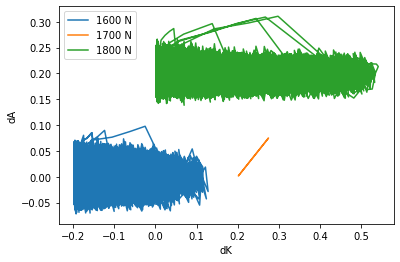

In [ ]:
print(N1600.shape)
print(yhat2[:340260, 0].shape)

N1800_cl = yhat2[680520:,0]
N1800_cl2 = yhat[:,0]
N1800cl = np.concatenate((N1800_cl, N1800_cl2)) + .2
print(N1800.shape)



plt.figure()
plt.plot(N1600, yhat2[:340260, 0], label="1600 N")
plt.plot(N1700, yhat2[340260:680520,3], label="1700 N")
plt.plot(N1800[:340260], N1800cl[:340260], label="1800 N")

plt.xlabel("dK")
plt.ylabel("dA")
plt.legend()
plt.show()

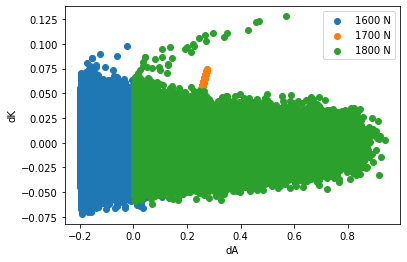

In [ ]:
plt.figure()
plt.scatter(N1600, yhat2[:340260, 0], label="1600 N")
plt.scatter(N1700, yhat2[340260:680520,3], label="1700 N")
plt.scatter(N1800, N1800cl, label="1800 N")

plt.xlabel("dA")
plt.ylabel("dK")
plt.legend()
plt.show()

In [ ]:
mae =  mean_absolute_error(y_test,yhat)
print(mae)

0.0045358444509218405


In [ ]:
#Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("allVars_Kminmax")

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("allVars")
print("Model Loaded")

Model Loaded
